In [29]:
# 온도에 따른 Ozone량 예측

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats     # 이상치 처리를 위해서 필요
import tensorflow as tf     # tensorflow 구현
from sklearn import linear_model  # sklearn으로 simple linear regression 구현
from sklearn.preprocessing import MinMaxScaler # normalization 전처리


# Raw Data Loading
df = pd.read_csv('./ozone.csv')
training_data = df[['Temp','Ozone']]   # 153 rows × 2 columns

# 결측치부터 처리해 보아요!
# 결측치를 찾아서 제거할꺼예요!
training_data = training_data.dropna(how='any')
# display(training_data)    # 116 rows × 2 columns

# 이상치 처리(outlier)
# z-score를 이용해서 outlier를 처리
zscore_threshold = 1.8

# Temp에 대한 outlier(지대점)
tmp = ~(np.abs(stats.zscore(training_data['Temp'])) > zscore_threshold)
training_data = training_data.loc[tmp]
# display(training_data)   # 110 rows × 2 columns

# Ozone에 대한 outlier
tmp = ~(np.abs(stats.zscore(training_data['Ozone'])) > zscore_threshold)
training_data = training_data.loc[tmp]
# display(training_data)   # 103 rows × 2 columns

###########################
# 정규화 처리를 진행(Min-Max Scaler)
# 직접구현해도 되지만 sklearn을 이용해서 처리해 보아요!

# Min-Max Scaler라고 불리는 객체를 생성
# 이 객체를 두개 만들꺼예요! 독립변수와 종속변수에 대해서 각각 만들어줘요!
scaler_x = MinMaxScaler()  # 객체 생성
scaler_t = MinMaxScaler()  # 객체 생성
scaler_x.fit(training_data['Temp'].values.reshape(-1,1))
scaler_t.fit(training_data['Ozone'].values.reshape(-1,1))
# print(scaler_x.n_samples_seen_, scaler_x.data_max_, 
#       scaler_x.data_min_, scaler_x.feature_range)
training_data['Temp'] = scaler_x.transform(training_data['Temp'].values.reshape(-1,1))
training_data['Ozone'] = scaler_t.transform(training_data['Ozone'].values.reshape(-1,1))

display(training_data)


# Training Data Set
x_data = training_data['Temp'].values.reshape(-1,1)
t_data = training_data['Ozone'].values.reshape(-1,1)

# placeholder
X = tf.placeholder(shape=[None,1], dtype=tf.float32)
T = tf.placeholder(shape=[None,1], dtype=tf.float32)

# Weight & bias
W = tf.Variable(tf.random.normal([1,1]), name='weight')
b = tf.Variable(tf.random.normal([1]), name='bias')

# Hypothesis
H = tf.matmul(X,W) + b

# loss function
loss = tf.reduce_mean(tf.square(H-T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# session, 초기화
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(300000):
    _, W_val, b_val, loss_val = sess.run([train, W, b, loss], 
                                         feed_dict={X: x_data, T: t_data})
    
    if step % 30000 == 0:
        print('W : {}, b : {}, loss : {}'.format(W_val,b_val,loss_val))

        

,Temp,Ozone
0,0.181818,0.397849
1,0.333333,0.344086
2,0.393939,0.086022
3,0.030303,0.150538
5,0.151515,0.258065
...,...,...
147,0.060606,0.107527
148,0.272727,0.279570
150,0.424242,0.107527
151,0.454545,0.150538


W : [[0.8269691]], b : [0.4849124], loss : 0.33244389295578003
W : [[0.65133786]], b : [0.02873686], loss : 0.031715042889118195
W : [[0.6899424]], b : [0.00782316], loss : 0.031066808849573135
W : [[0.71819574]], b : [-0.00728018], loss : 0.03072146512567997
W : [[0.7387661]], b : [-0.01829256], loss : 0.030537711456418037
W : [[0.75377697]], b : [-0.0263338], loss : 0.030439654365181923
W : [[0.7647239]], b : [-0.03219307], loss : 0.030387332662940025
W : [[0.77269214]], b : [-0.03642933], loss : 0.030359458178281784
W : [[0.7785003]], b : [-0.03952605], loss : 0.030344506725668907
W : [[0.78264076]], b : [-0.04177269], loss : 0.03033660538494587


In [31]:
# sklearn을 이용해서 구현해 보아요!
# Training Data Set
x_data = training_data['Temp'].values.reshape(-1,1)
t_data = training_data['Ozone'].values.reshape(-1,1)

model = linear_model.LinearRegression()
model.fit(x_data,t_data)

print('W : {}, b : {}'.format(model.coef_, model.intercept_))

W : [[0.79468511]], b : [-0.04818192]


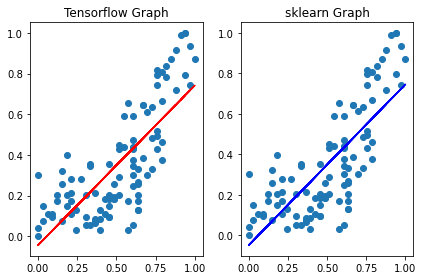

In [34]:
# Graph로 비교해 보아요!!
fig = plt.figure()
fig_tensorflow = fig.add_subplot(1,2,1)
fig_sklearn = fig.add_subplot(1,2,2)

fig_tensorflow.set_title('Tensorflow Graph')
fig_sklearn.set_title('sklearn Graph')

fig_tensorflow.scatter(x_data,t_data)
fig_tensorflow.plot(x_data,x_data*W_val.ravel() + b_val, color='r')

fig_sklearn.scatter(x_data,t_data)
fig_sklearn.plot(x_data,x_data*model.coef_.ravel() + model.intercept_, color='b')

fig.tight_layout()
plt.show()



In [37]:
# prediction
# 온도가 62도 일때 Ozone은 얼마일까요??

# sklearn을 이용
sklearn_result = model.predict([[62]])
print(sklearn_result)    # [[49.22229492]]

# tensorflow를 이용
tensorflow_result = sess.run(H, feed_dict={X:[[62]]})
print(tensorflow_result)

[[49.22229492]]
[[48.692375]]


In [51]:
# Multiple Linear Regression
# 온도, 태양광세기, 바람세기을 이용하여 Ozone량을 예측

import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model

# Raw Data Loading
df = pd.read_csv('./ozone.csv')

# 학습에 필요한 데이터부터 추출
training_data = df[['Temp','Wind','Solar.R','Ozone']]
# display(training_data)   # 153 rows × 4 columns

# 결측치 처리
training_data = training_data.dropna(how='any')
# display(training_data) # 111 rows × 4 columns

# 이상치 처리
zscore_threshold = 1.8

for col in training_data.columns:
    tmp = ~(np.abs(stats.zscore(training_data[col])) > zscore_threshold)
    training_data = training_data.loc[tmp]

#display(training_data)   # (86, 4)

# 정규화 처리
scaler_x = MinMaxScaler()  # 객체 생성
scaler_t = MinMaxScaler()  # 객체 생성
scaler_x.fit(training_data[['Temp','Wind','Solar.R']].values)
scaler_t.fit(training_data['Ozone'].values.reshape(-1,1))

training_data_x = scaler_x.transform(training_data[['Temp','Wind','Solar.R']].values)
training_data_t = scaler_t.transform(training_data['Ozone'].values.reshape(-1,1))

# Tensorflow 코드

# placeholder
X = tf.placeholder(shape=[None,3], dtype=tf.float32)
T = tf.placeholder(shape=[None,1], dtype=tf.float32)

# Weight & bias
W = tf.Variable(tf.random.normal([3,1]), name='weight')
b = tf.Variable(tf.random.normal([1]), name='bias')

# Hypothesis
H = tf.matmul(X,W) + b

# loss function
loss = tf.reduce_mean(tf.square(H-T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# session, 초기화
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(300000):
    _, W_val, b_val, loss_val = sess.run([train, W, b, loss], 
                                         feed_dict={X: training_data_x, 
                                                    T: training_data_t})
    
    if step % 30000 == 0:
        print('W : {}, b : {}, loss : {}'.format(W_val,b_val,loss_val))

    

W : [[-1.1781368]
 [ 0.5232747]
 [-0.2670319]], b : [0.00407235], loss : 1.141149640083313
W : [[-0.35150734]
 [ 0.22058156]
 [ 0.05164513]], b : [0.41639623], loss : 0.1433829814195633
W : [[-0.00205574]
 [-0.08379086]
 [ 0.08205004]], b : [0.36026284], loss : 0.06879407912492752
W : [[ 0.21653816]
 [-0.25187153]
 [ 0.10378608]], b : [0.31256917], loss : 0.04196026176214218
W : [[ 0.35618556]
 [-0.34128743]
 [ 0.1198138 ]], b : [0.27199894], loss : 0.031959258019924164
W : [[ 0.44774532]
 [-0.38575116]
 [ 0.13197799]], b : [0.23745094], loss : 0.02798733301460743
W : [[ 0.50962603]
 [-0.4049164 ]
 [ 0.14146617]], b : [0.20800434], loss : 0.02624373696744442
W : [[ 0.55284667]
 [-0.41020465]
 [ 0.14900368]], b : [0.18291703], loss : 0.0253729410469532
W : [[ 0.58405435]
 [-0.40819392]
 [ 0.15512569]], b : [0.16153198], loss : 0.02487729862332344
W : [[ 0.6074001 ]
 [-0.40262565]
 [ 0.1600911 ]], b : [0.14329652], loss : 0.02456396073102951


In [72]:
# 예측값을 한번 구해보아요!!
# tensorflow를 이용해서 만든 모델로 예측값을 구하고
# sklearn으로 구현한 모델을 이용해서 예측값을 구해서 
# 값을 비교해 보아요!
# 예측을 할 값은 => (온도, 바람, 태양광세기) => [80,10,150])
# ???
predict_data = np.array([[80,10,150]])
scaled_predict_data = scaler_x.transform(predict_data)

tensorflow_result = sess.run(H, feed_dict={X:scaled_predict_data})

tensorflow_result = scaler_t.inverse_transform(tensorflow_result)

print(tensorflow_result)

[[38.91777]]


In [69]:
model = linear_model.LinearRegression()
# model.fit(training_data_x,training_data_t)
model.fit(training_data[['Temp','Wind','Solar.R']].values,
         training_data['Ozone'].values.reshape(-1,1))

# sklearn은 머신러닝내용을 모르는 사람도 데이터를 쉽게 학습해서
# 예측값을 알아낼 수 있도록 모듈화 시켜서 우리에게 제공!

# print('W : {}, b : {}'.format(model.coef_, model.intercept_))
print(model.predict([[80.0,10.0,150.0]]))

[[38.8035437]]
